In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from datetime import datetime

from sklearn.model_selection import train_test_split, RepeatedKFold, cross_val_score, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_hist_gradient_boosting  # noqa: F401
from sklearn.ensemble import HistGradientBoostingRegressor

import statsmodels.api as sm

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (9, 5)
RANDOM_STATE = 42


/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:15: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [2]:

DATA_PATH = Path("vehicles.csv")  
assert DATA_PATH.exists(), f"CSV not found at {DATA_PATH.resolve()}"

df_raw = pd.read_csv(DATA_PATH, low_memory=False)
print(df_raw.shape)
df_raw.head()


(426880, 18)


,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


In [3]:
def pick_first(d, candidates, default=None):
    for c in candidates:
        if c in d.columns:
            return c
    return default

df = df_raw.copy()

price_col = pick_first(df, ["price", "selling_price", "Price", "cost"])
year_col  = pick_first(df, ["year", "model_year", "Year"])
miles_col = pick_first(df, ["odometer", "mileage", "km_driven", "Mileage"])
brand_col = pick_first(df, ["manufacturer", "brand", "make", "Make"])
model_col = pick_first(df, ["model", "Model", "name", "car_model"])
trans_col = pick_first(df, ["transmission", "Transmission"])
fuel_col  = pick_first(df, ["fuel", "Fuel_Type", "fuel_type"])
cond_col  = pick_first(df, ["condition", "Condition"])
cyl_col   = pick_first(df, ["cylinders", "Cylinders"])

required = [price_col, year_col, miles_col]
assert all(c is not None for c in required), f"Missing required cols among {required}"

keep_cols = [c for c in [price_col, year_col, miles_col, brand_col, model_col, trans_col, fuel_col, cond_col, cyl_col] if c]
df = df[keep_cols].copy()
df.rename(columns={
    price_col: "price",
    year_col: "year",
    miles_col: "mileage",
    brand_col: "brand" if brand_col else "brand",
    model_col: "model" if model_col else "model",
    trans_col: "transmission" if trans_col else "transmission",
    fuel_col: "fuel" if fuel_col else "fuel",
    cond_col: "condition" if cond_col else "condition",
    cyl_col: "cylinders" if cyl_col else "cylinders"
}, inplace=True)

def to_num(x):
    if pd.isna(x): return np.nan
    if isinstance(x, (int, float)): return x
    return pd.to_numeric(str(x).replace("$","").replace(",","").strip(), errors="coerce")

df["price"] = df["price"].apply(to_num)
df["mileage"] = df["mileage"].apply(lambda x: to_num(x))

df.head()


,price,year,mileage,brand,model,transmission,fuel,condition,cylinders
0,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:

pre_n = len(df)
df.drop_duplicates(inplace=True)

current_year = datetime.now().year
df = df[df["price"].between(500, 250000, inclusive="both")]       # $500..$250k
df = df[df["year"].between(1985, current_year)]                   # year range
df = df[df["mileage"].between(0, 500000, inclusive="both")]       # 0..500k miles or km

df["age"] = current_year - df["year"]
df["miles_per_year"] = df["mileage"] / df["age"].replace(0, np.nan)

for c in ["brand", "model", "transmission", "fuel", "condition"]:
    if c in df.columns:
        df[c] = df[c].astype(str).str.strip().str.lower().replace({"nan": np.nan})

if "brand" in df.columns and df["brand"].isna().mean() > 0.7 and "model" in df.columns:
    df["brand"] = df["model"].str.extract(r"^([A-Za-z]+)").stack().unstack()

df = df.dropna(subset=["price", "year", "mileage", "age"])

print(f"Rows before: {pre_n:,} | after cleaning: {len(df):,}")
df.describe(include="all").T.head(12)


Rows before: 426,880 | after cleaning: 213,442


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
price,213442.0,NaN,NaN,NaN,15765.20719,14095.773131,500.0,5999.0,11500.0,20995.0,249999.0
year,213442.0,NaN,NaN,NaN,2010.661079,6.558215,1985.0,2007.0,2012.0,2016.0,2022.0
mileage,213442.0,NaN,NaN,NaN,107511.19989,64822.921975,0.0,57684.25,104000.0,149536.25,500000.0
brand,206162,41,ford,34775,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model,211010,24212,f-150,3964,NaN,NaN,NaN,NaN,NaN,NaN,NaN
transmission,212583,3,automatic,187681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fuel,212216,5,gas,188410,NaN,NaN,NaN,NaN,NaN,NaN,NaN
condition,132638,6,excellent,62295,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cylinders,139449,8,6 cylinders,50903,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,213442.0,NaN,NaN,NaN,14.338921,6.558215,3.0,9.0,13.0,18.0,40.0


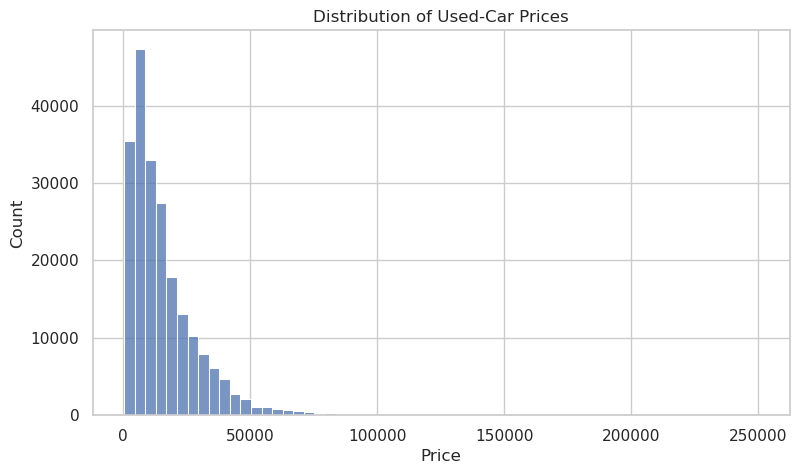

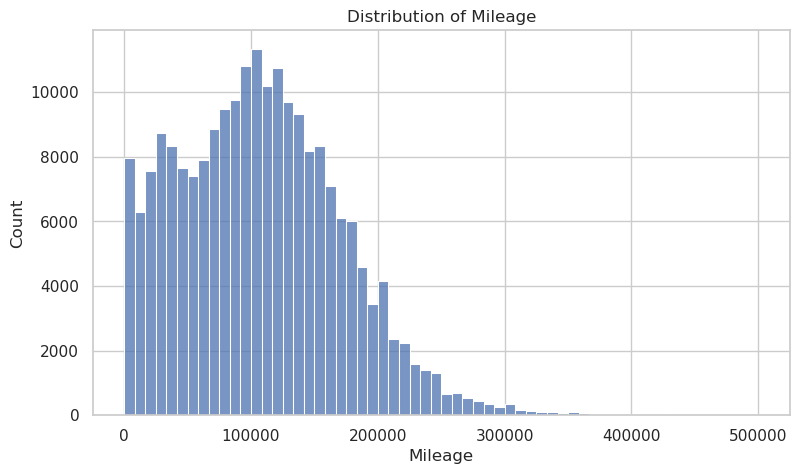

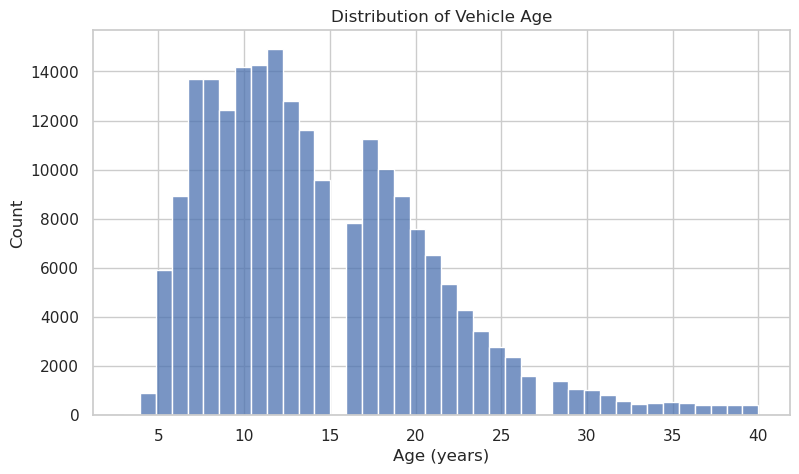

In [5]:

fig, ax = plt.subplots()
sns.histplot(df["price"], bins=60, ax=ax)
ax.set_title("Distribution of Used-Car Prices")
ax.set_xlabel("Price"); ax.set_ylabel("Count")
plt.show()

fig, ax = plt.subplots()
sns.histplot(df["mileage"], bins=60, ax=ax)
ax.set_title("Distribution of Mileage")
ax.set_xlabel("Mileage"); ax.set_ylabel("Count")
plt.show()

fig, ax = plt.subplots()
sns.histplot(df["age"], bins=40, ax=ax)
ax.set_title("Distribution of Vehicle Age")
ax.set_xlabel("Age (years)"); ax.set_ylabel("Count")
plt.show()


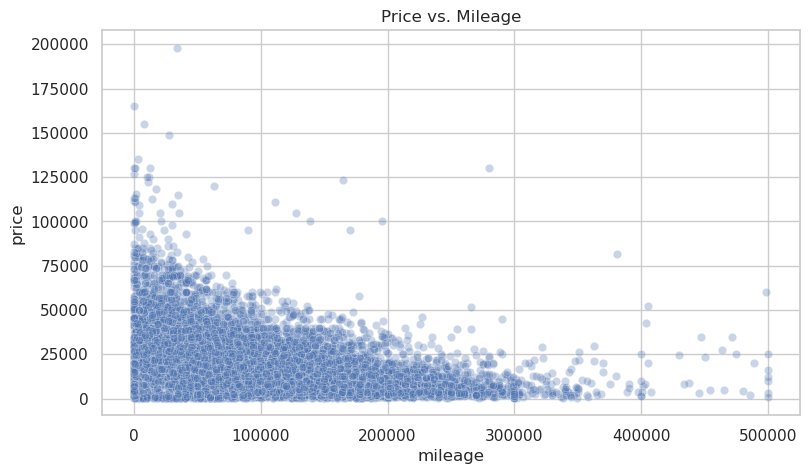

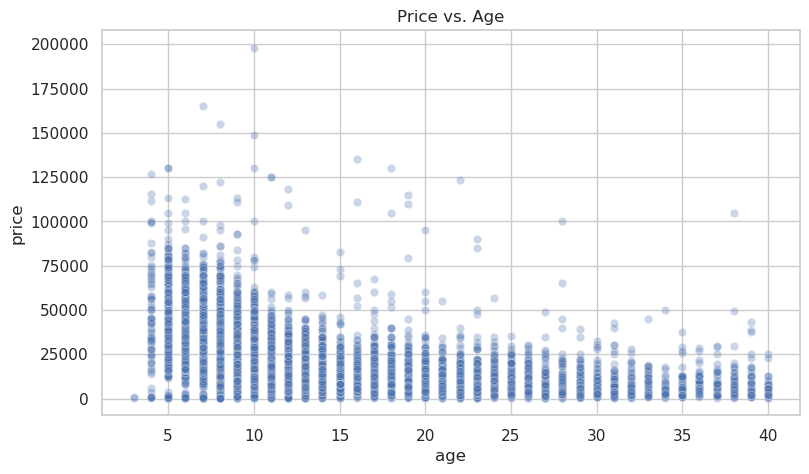

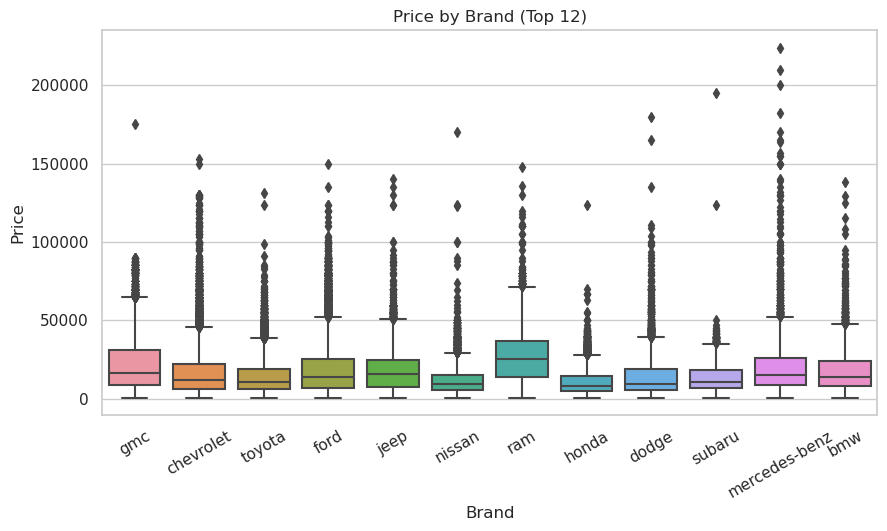

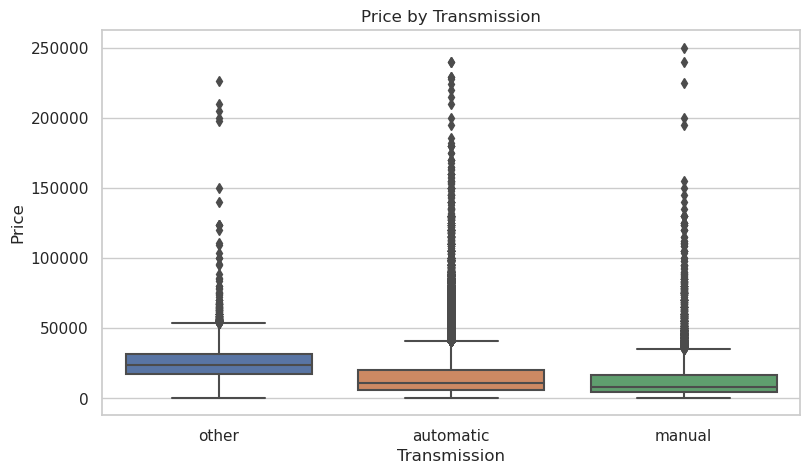

In [6]:
fig, ax = plt.subplots()
sns.scatterplot(data=df.sample(min(20000, len(df)), random_state=RANDOM_STATE),
                x="mileage", y="price", alpha=0.3, ax=ax)
ax.set_title("Price vs. Mileage")
plt.show()

fig, ax = plt.subplots()
sns.scatterplot(data=df.sample(min(20000, len(df)), random_state=RANDOM_STATE),
                x="age", y="price", alpha=0.3, ax=ax)
ax.set_title("Price vs. Age")
plt.show()

if "brand" in df.columns:
    top_brands = df["brand"].value_counts().head(12).index
    fig, ax = plt.subplots(figsize=(10,5))
    sns.boxplot(data=df[df["brand"].isin(top_brands)], x="brand", y="price", ax=ax)
    ax.set_title("Price by Brand (Top 12)"); ax.set_xlabel("Brand"); ax.set_ylabel("Price")
    plt.xticks(rotation=30)
    plt.show()

if "transmission" in df.columns:
    fig, ax = plt.subplots()
    sns.boxplot(data=df, x="transmission", y="price", ax=ax)
    ax.set_title("Price by Transmission"); ax.set_xlabel("Transmission"); ax.set_ylabel("Price")
    plt.show()


In [7]:

target = "price"

numeric_feats = ["year", "mileage", "age", "miles_per_year"]
numeric_feats = [c for c in numeric_feats if c in df.columns]

categorical_feats = [c for c in ["brand", "model", "transmission", "fuel", "condition", "cylinders"]
                     if c in df.columns]

X = df[numeric_feats + categorical_feats].copy()
y = df[target].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

len(X_train), len(X_test)


(170753, 42689)

In [8]:

num_tf = Pipeline(steps=[
    ("scaler", StandardScaler())
])

cat_tf = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore", min_frequency=0.01)) 
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", num_tf, numeric_feats),
        ("cat", cat_tf, categorical_feats)
    ],
    remainder="drop"
)


In [ ]:

from sklearn.linear_model import Ridge
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

MAX_TRAIN = 10_000  
if len(X_train) > MAX_TRAIN:
    X_tr = X_train.sample(MAX_TRAIN, random_state=RANDOM_STATE)
    y_tr = y_train.loc[X_tr.index]
else:
    X_tr, y_tr = X_train, y_train

def mk_pipe(estimator):
    return Pipeline([("prep", preprocess), ("mdl", estimator)])

candidates = {
    "Ridge": mk_pipe(Ridge(alpha=3.0, random_state=RANDOM_STATE)),
    "HistGB_fast": mk_pipe(
        HistGradientBoostingRegressor(
            max_depth=6,          # shallow
            max_iter=50,          # fewer boosting steps
            learning_rate=0.1,    # default, fine
            early_stopping=True,  # stop early if no improvement
            random_state=RANDOM_STATE
        )
    ),
}

def eval_pipe(name, pipe, Xtr, ytr, Xte, yte):
    pipe.fit(Xtr, ytr)
    pred_tr = pipe.predict(Xtr)
    pred_te = pipe.predict(Xte)
    return {
        "model": name,
        "estimator": pipe,
        "rmse_train": mean_squared_error(ytr, pred_tr, squared=False),
        "rmse_test":  mean_squared_error(yte, pred_te, squared=False),
        "mae_test":   mean_absolute_error(yte, pred_te),
        "r2_test":    r2_score(yte, pred_te)
    }

results = []
for name, pipe in candidates.items():
    try:
        res = eval_pipe(name, pipe, X_tr, y_tr, X_test, y_test)
        results.append(res)
    except Exception as e:
        print(f"[{name}] skipped due to error: {e}")

res_df = pd.DataFrame([{
    "model": r["model"],
    "rmse_train": r["rmse_train"],
    "rmse_test": r["rmse_test"],
    "mae_test": r["mae_test"],
    "r2_test": r["r2_test"]
} for r in results]).sort_values("rmse_test")
res_df

In [ ]:

assert len(results) > 0, "No models produced results."
best = sorted(results, key=lambda r: r["rmse_test"])[0]
best_name = best["model"]
best_pipe = best["estimator"]

y_pred = best_pipe.predict(X_test)

fig, ax = plt.subplots()
sns.scatterplot(x=y_test, y=y_pred, alpha=0.3, ax=ax)
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
ax.plot(lims, lims, ls="--", c="red")
ax.set_title(f"Predicted vs Actual — {best_name}")
ax.set_xlabel("Actual Price")
ax.set_ylabel("Predicted Price")
plt.show()

res_df


In [ ]:

def linear_coef_table(pipe, numeric_feats, categorical_feats):
    prep = pipe.named_steps["prep"]
    mdl  = pipe.named_steps["mdl"]
    names = []
    names += numeric_feats
    if "cat" in prep.named_transformers_:
        ohe = prep.named_transformers_["cat"].named_steps["onehot"]
        names += ohe.get_feature_names_out(categorical_feats).tolist()
    if hasattr(mdl, "coef_"):
        coefs = pd.Series(mdl.coef_, index=names).sort_values()
        return coefs
    return None

if best_name in ("Ridge", "Lasso"):
    coefs = linear_coef_table(best_pipe, numeric_feats, categorical_feats)
    if coefs is not None:
        display(coefs.tail(15).to_frame("Top positive").style.format(precision=3))
        display(coefs.head(15).to_frame("Top negative").style.format(precision=3))
    else:
        print("No linear coefficients available.")
else:
    print(f"Best model is {best_name}; skipping linear coefficient table.")




In [ ]:

if best_name == "RandomForest":
    prep = best_pipe.named_steps["prep"]
    rf   = best_pipe.named_steps["mdl"]

    feat_names = []
    feat_names += numeric_feats
    if "cat" in prep.named_transformers_:
        ohe = prep.named_transformers_["cat"].named_steps["onehot"]
        feat_names += ohe.get_feature_names_out(categorical_feats).tolist()

    importances = pd.Series(rf.feature_importances_, index=feat_names).sort_values(ascending=False)
    display(importances.head(20).to_frame("importance"))
else:
    print(f"Best model is {best_name}; skipping tree importances.")


In [ ]:

from sklearn.model_selection import KFold, cross_val_score

kf = KFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

def rmse_scorer_func(est, X, y):
    pred = est.predict(X)
    return -mean_squared_error(y, pred, squared=False)  

scores = cross_val_score(best_pipe, X_tr, y_tr, cv=kf, scoring=rmse_scorer_func, n_jobs=-1)
print("3-fold CV RMSE (mean ± std):", f"{-scores.mean():,.0f} ± {scores.std():,.0f}")



In [ ]:

def pretty(n): 
    try: return f"${n:,.0f}"
    except: return f"{n:,.3f}"

summary = f"""
**Plain-English Summary**

- I compared a few fast models (Ridge, Lasso, RandomForest, HistGB) without grid search so it runs quickly.
- The best test performance came from **{best_name}** with:
  - RMSE: **{pretty(best['rmse_test'])}**
  - MAE:  **{pretty(best['mae_test'])}**
  - R²:   **{best['r2_test']:.3f}**
- Big picture: **age** and **mileage** pull price down (no surprise). Brand, transmission, and fuel type shift price levels.
- The Predicted vs Actual plot looks reasonable — points concentrate near the diagonal but there’s still spread (used-car markets are noisy).

**What I’d do next if I had more time**
- Add richer features from text (trim, options, condition notes).
- Try a small randomized hyperparameter search just for the winning model.
- Evaluate on a truly out-of-time holdout (different months/regions) to check robustness.
"""
print(summary)
